In [ ]:
# Nouveau: séparer aléatoirement les cas en train (18) / val (5) et créer try_1
from pathlib import Path
from shutil import copy2
import random

parent = Path.cwd().parent
ravir_train = parent / 'RAVIR Dataset' / 'train'
imgs_dir = ravir_train / 'training_images'
masks_dir = ravir_train / 'training_masks'
try_dir = parent / 'try_1'

if try_dir.exists():
    print(f"'{try_dir}' existe — séparation ignorée.")
else:
    imgs = sorted(imgs_dir.glob('*.png'))
    cases = [p.stem for p in imgs]  # ex: 'IR_Case_01'
    random.seed(42)
    random.shuffle(cases)
    if len(cases) >= 23:
        n_train = 18
    else:
        n_train = int(round(0.8 * len(cases)))
    train_cases = cases[:n_train]
    val_cases = cases[n_train:]

    train_dest = try_dir / 'train'
    val_dest = try_dir / 'val'
    for d in [train_dest / 'training_images', train_dest / 'training_masks', val_dest / 'training_images', val_dest / 'training_masks']:
        d.mkdir(parents=True, exist_ok=True)

    def copy_pairs(case_list, dest_base):
        for stem in case_list:
            img_src = imgs_dir / (stem + '.png')
            mask_src = masks_dir / (stem + '.png')
            if img_src.exists():
                copy2(img_src, dest_base / 'training_images' / img_src.name)
            else:
                print(f'Missing image: {img_src}')
            if mask_src.exists():
                copy2(mask_src, dest_base / 'training_masks' / mask_src.name)
            else:
                print(f'Missing mask: {mask_src}')

    copy_pairs(train_cases, train_dest)
    copy_pairs(val_cases, val_dest)
    print(f'Copied {len(train_cases)} train and {len(val_cases)} val cases into {try_dir}')

In [ ]:
# Just print the number of images and masks in the RAVIR dataset

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import math

base = Path.cwd().parent / 'RAVIR Dataset' / 'train'
imgs_dir = base / 'training_images'
masks_dir = base / 'training_masks'

def list_pngs(folder):
    return sorted(folder.glob('*.png'))

def show_grid(paths, title=None, cols=5, thumb_size=(256,256)):
    n = len(paths)
    if n == 0:
        print(f"No images in {paths}")
        return
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols*3, rows*3))
    for i, p in enumerate(paths):
        img = Image.open(p).convert('RGB')
        img.thumbnail(thumb_size)
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(p.name, fontsize=8)
        ax.axis('off')
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

imgs = list_pngs(imgs_dir)
masks = list_pngs(masks_dir)

print(f"Images found: {len(imgs)}  Masks found: {len(masks)}")
show_grid(imgs, title='Training images', cols=5)
show_grid(masks, title='Training masks', cols=5)

# UNet

### Imports nécessaires

In [1]:
import os
import random
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

PyTorch version: 2.9.0+cpu
Device: cpu


### UNet Parameters

In [2]:
# Paramètres
parent = Path.cwd().parent
data_root = parent / 'try_1'
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 30
LR = 1e-4
NUM_CLASSES = 3  # 0: background, 1: arteries (white), 2: veins (gray)
SEED = 42

train_imgs_dir = data_root / 'train' / 'training_images'
train_masks_dir = data_root / 'train' / 'training_masks'
val_imgs_dir = data_root / 'val' / 'training_images'
val_masks_dir = data_root / 'val' / 'training_masks'

print('Train images folder exists:', train_imgs_dir.exists())
print('Val images folder exists:', val_imgs_dir.exists())

Train images folder exists: True
Val images folder exists: True


### UNet Model

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, n_classes=NUM_CLASSES, in_channels=3, features=[32,64,128,256]):
        super().__init__()
        self.encs = nn.ModuleList()
        self.pools = nn.ModuleList()
        for f in features:
            self.encs.append(DoubleConv(in_channels, f))
            self.pools.append(nn.MaxPool2d(2))
            in_channels = f
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # decoder
        self.upconvs = nn.ModuleList()
        self.decs = nn.ModuleList()
        for f in reversed(features):
            self.upconvs.append(nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2))
            self.decs.append(DoubleConv(f*2, f))
        self.final_conv = nn.Conv2d(features[0], n_classes, kernel_size=1)

    def forward(self, x):
        skips = []
        for enc, pool in zip(self.encs, self.pools):
            x = enc(x)
            skips.append(x)
            x = pool(x)
        x = self.bottleneck(x)
        for up, dec, skip in zip(self.upconvs, self.decs, reversed(skips)):
            x = up(x)
            # pad if needed
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = dec(x)
        x = self.final_conv(x)
        return x

model = UNet().to(device)
print(model)

UNet(
  (encs): ModuleList(
    (0): DoubleConv(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (3): DoubleConv(
      (net): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

### Loss function

In [4]:
criterion = nn.CrossEntropyLoss()  # expects raw logits and class indices in [0..C-1]
optimizer = optim.Adam(model.parameters(), lr=LR)
print('Criterion and optimizer ready')

Criterion and optimizer ready


### Model train

In [5]:
# mapping colors to labels: black->0, white->1 (arteries), gray->2 (veins)
COLOR_TO_LABEL = {
    (0,0,0): 0,
    (255,255,255): 1,
    (128,128,128): 2
}

class RAVIRDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=IMG_SIZE, transforms=None):
        self.img_paths = sorted(list(Path(img_dir).glob('*.png')))
        self.mask_dir = Path(mask_dir)
        self.img_size = img_size
        self.transforms = transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_p = self.img_paths[idx]
        mask_p = self.mask_dir / img_p.name
        img = Image.open(img_p).convert('RGB').resize(self.img_size, Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 255.0
        img = np.transpose(img, (2,0,1))  # C,H,W
        img_t = torch.from_numpy(img).float()
        # load mask and map colors to labels
        m = Image.open(mask_p).convert('RGB').resize(self.img_size, Image.NEAREST)
        m_arr = np.array(m, dtype=np.uint8)
        label = np.zeros((self.img_size[1], self.img_size[0]), dtype=np.uint8)
        for color, lab in COLOR_TO_LABEL.items():
            mask = np.all(m_arr == np.array(color, dtype=np.uint8), axis=-1)
            label[mask] = lab
        label_t = torch.from_numpy(label).long()  # H,W
        return img_t, label_t

train_ds = RAVIRDataset(train_imgs_dir, train_masks_dir, IMG_SIZE)
val_ds = RAVIRDataset(val_imgs_dir, val_masks_dir, IMG_SIZE)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# helper for IoU
def compute_mean_iou(preds, labels, num_classes=NUM_CLASSES):
    preds = preds.view(-1)
    labels = labels.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    # mean over classes ignoring NaNs
    ious = np.array(ious, dtype=np.float32)
    return np.nanmean(ious)

history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[], 'train_miou':[], 'val_miou':[]}

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    miou_sum = 0.0
    batches = 0
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)  # N,C,H,W
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == masks).sum().item()
        total += masks.numel()
        miou_sum += compute_mean_iou(preds.cpu(), masks.cpu())
        batches += 1
    train_loss = running_loss / len(train_ds) if len(train_ds)>0 else 0
    train_acc = correct / total if total>0 else 0
    train_miou = miou_sum / batches if batches>0 else 0

    # validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    miou_sum = 0.0
    batches = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == masks).sum().item()
            total += masks.numel()
            miou_sum += compute_mean_iou(preds.cpu(), masks.cpu())
            batches += 1
    val_loss = val_loss / len(val_ds) if len(val_ds)>0 else 0
    val_acc = correct / total if total>0 else 0
    val_miou = miou_sum / batches if batches>0 else 0

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_miou'].append(train_miou)
    history['val_miou'].append(val_miou)

    print(f'Epoch {epoch}/{EPOCHS} - train_loss: {train_loss:.4f} val_loss: {val_loss:.4f} train_acc: {train_acc:.4f} val_acc: {val_acc:.4f} train_miou: {train_miou:.4f} val_miou: {val_miou:.4f}')

Epoch 1/30 - train_loss: 1.0794 val_loss: 1.0731 train_acc: 0.0532 val_acc: 0.0590 train_miou: 0.0179 val_miou: 0.0197
Epoch 2/30 - train_loss: 1.0725 val_loss: 1.0668 train_acc: 0.0533 val_acc: 0.1921 train_miou: 0.0177 val_miou: 0.0731
Epoch 2/30 - train_loss: 1.0725 val_loss: 1.0668 train_acc: 0.0533 val_acc: 0.1921 train_miou: 0.0177 val_miou: 0.0731
Epoch 3/30 - train_loss: 1.0663 val_loss: 1.0604 train_acc: 0.4742 val_acc: 0.8576 train_miou: 0.2054 val_miou: 0.2919
Epoch 3/30 - train_loss: 1.0663 val_loss: 1.0604 train_acc: 0.4742 val_acc: 0.8576 train_miou: 0.2054 val_miou: 0.2919
Epoch 4/30 - train_loss: 1.0600 val_loss: 1.0537 train_acc: 0.8575 val_acc: 0.8693 train_miou: 0.2909 val_miou: 0.2911
Epoch 4/30 - train_loss: 1.0600 val_loss: 1.0537 train_acc: 0.8575 val_acc: 0.8693 train_miou: 0.2909 val_miou: 0.2911
Epoch 5/30 - train_loss: 1.0534 val_loss: 1.0473 train_acc: 0.8700 val_acc: 0.8724 train_miou: 0.2929 val_miou: 0.2908
Epoch 5/30 - train_loss: 1.0534 val_loss: 1.0473

### Sauvegarde le

In [6]:
save_dir = parent / 'try_1'
save_dir.mkdir(parents=True, exist_ok=True)
model_path = save_dir / 'unet_pytorch.pth'
torch.save(model.state_dict(), str(model_path))
print('Model state_dict saved to', model_path)

Model state_dict saved to c:\Users\User\4TC\S1 - Tohoku\Labo\try_1\unet_pytorch.pth


### Affiche les courbes de loss, et autres données intéréssantes à visualiser pour l'entrainement

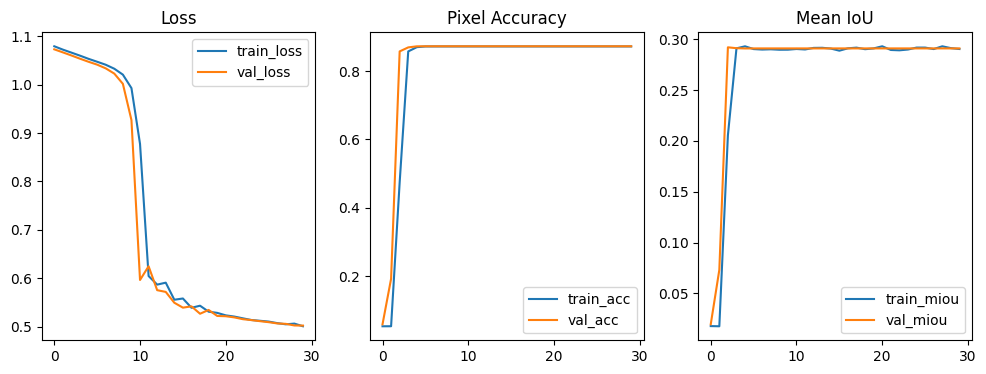

Done. Inspect c:\Users\User\4TC\S1 - Tohoku\Labo\try_1


In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.legend(); plt.title('Pixel Accuracy')
plt.subplot(1,3,3)
plt.plot(history['train_miou'], label='train_miou')
plt.plot(history['val_miou'], label='val_miou')
plt.legend(); plt.title('Mean IoU')
plt.show()

print('Done. Inspect', save_dir)

### Évaluation sur l'ensemble de validation (5 images)
Affiche pour chaque image : image originale, mask ground-truth et prédiction. Calcule pixel-accuracy, IoU par classe et mean IoU.

Loaded model from c:\Users\User\4TC\S1 - Tohoku\Labo\try_1\unet_pytorch.pth


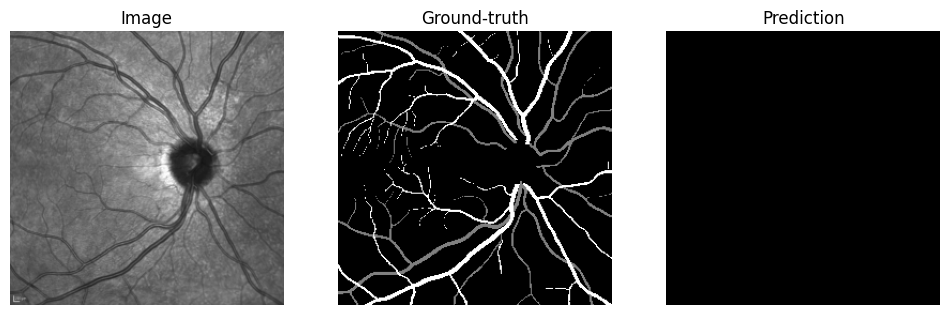

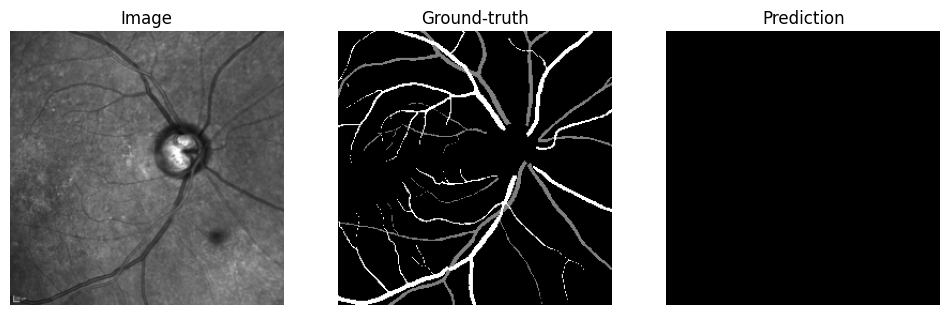

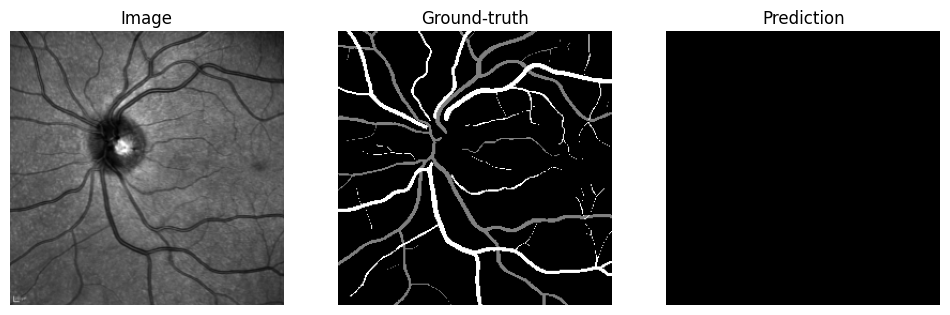

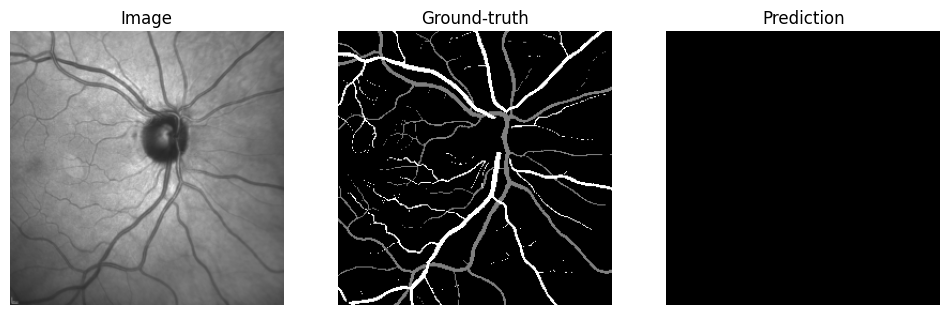

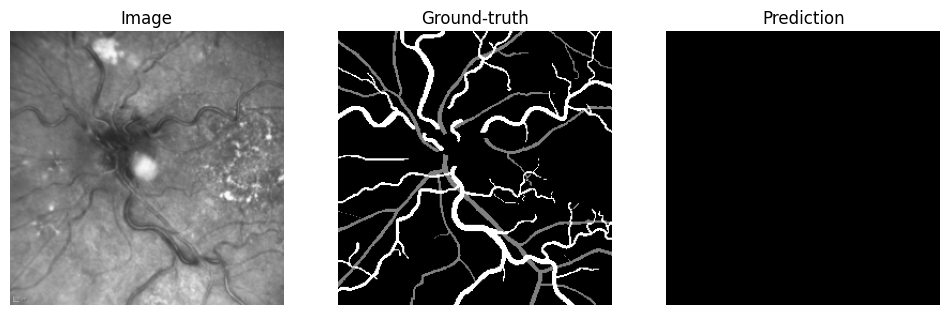

Validation results:
Pixel Accuracy: 0.8725
 Class 0 IoU: 0.872540283203125
 Class 1 IoU: 0.0
 Class 2 IoU: 0.0
Mean IoU: 0.2908


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

# restore model if needed
model_path = parent / 'try_1' / 'unet_pytorch.pth'
if model_path.exists():
    model.load_state_dict(torch.load(str(model_path), map_location=device))
    model.to(device)
    print('Loaded model from', model_path)
else:
    print('No saved state_dict found, using in-memory model')

COLOR_MAP = {0: (0,0,0), 1: (255,255,255), 2: (128,128,128)}

def colorize_mask(mask):
    # mask: H,W (numpy) values 0..2 -> RGB uint8
    h,w = mask.shape
    out = np.zeros((h,w,3), dtype=np.uint8)
    for k,v in COLOR_MAP.items():
        out[mask==k] = v
    return out

def evaluate_and_show(val_ds, max_display=10):
    model.eval()
    total_pixels = 0
    correct_pixels = 0
    class_intersections = np.zeros(NUM_CLASSES, dtype=np.float64)
    class_unions = np.zeros(NUM_CLASSES, dtype=np.float64)
    displayed = 0

    for idx in range(len(val_ds)):
        img_t, mask_t = val_ds[idx]  # img_t: C,H,W tensor, mask_t: H,W tensor
        img = img_t.unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(img)  # N,C,H,W
            pred = out.argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8)
        gt = mask_t.numpy().astype(np.uint8)
        # metrics
        total_pixels += gt.size
        correct_pixels += (pred == gt).sum()
        for c in range(NUM_CLASSES):
            pred_c = (pred == c)
            gt_c = (gt == c)
            inter = np.logical_and(pred_c, gt_c).sum()
            union = np.logical_or(pred_c, gt_c).sum()
            class_intersections[c] += inter
            class_unions[c] += union

        # display
        if displayed < max_display:
            img_disp = np.transpose(img_t.numpy(), (1,2,0))  # H,W,3 in [0,1]
            gt_col = colorize_mask(gt)
            pred_col = colorize_mask(pred)
            fig, axes = plt.subplots(1,3, figsize=(12,4))
            axes[0].imshow(img_disp); axes[0].set_title('Image'); axes[0].axis('off')
            axes[1].imshow(gt_col); axes[1].set_title('Ground-truth'); axes[1].axis('off')
            axes[2].imshow(pred_col); axes[2].set_title('Prediction'); axes[2].axis('off')
            plt.show()
            displayed += 1

    pixel_acc = correct_pixels / total_pixels if total_pixels>0 else 0
    ious = []
    for c in range(NUM_CLASSES):
        if class_unions[c] == 0:
            ious.append(float('nan'))
        else:
            ious.append(class_intersections[c] / class_unions[c])
    mean_iou = np.nanmean(ious)
    print('Validation results:')
    print(f'Pixel Accuracy: {pixel_acc:.4f}')
    for c, iou in enumerate(ious):
        print(f' Class {c} IoU: {iou if not np.isnan(iou) else "n/a"}')
    print(f'Mean IoU: {mean_iou:.4f}')
    return {'pixel_acc': pixel_acc, 'ious': ious, 'mean_iou': mean_iou}

# run on validation dataset (the val_ds defined earlier)
val_metrics = evaluate_and_show(val_ds, max_display=5)

### Application du modèle sur les images de c:\RAVIR Dataset\train (pas de masques)
Affiche les images originales et les prédictions (grille).

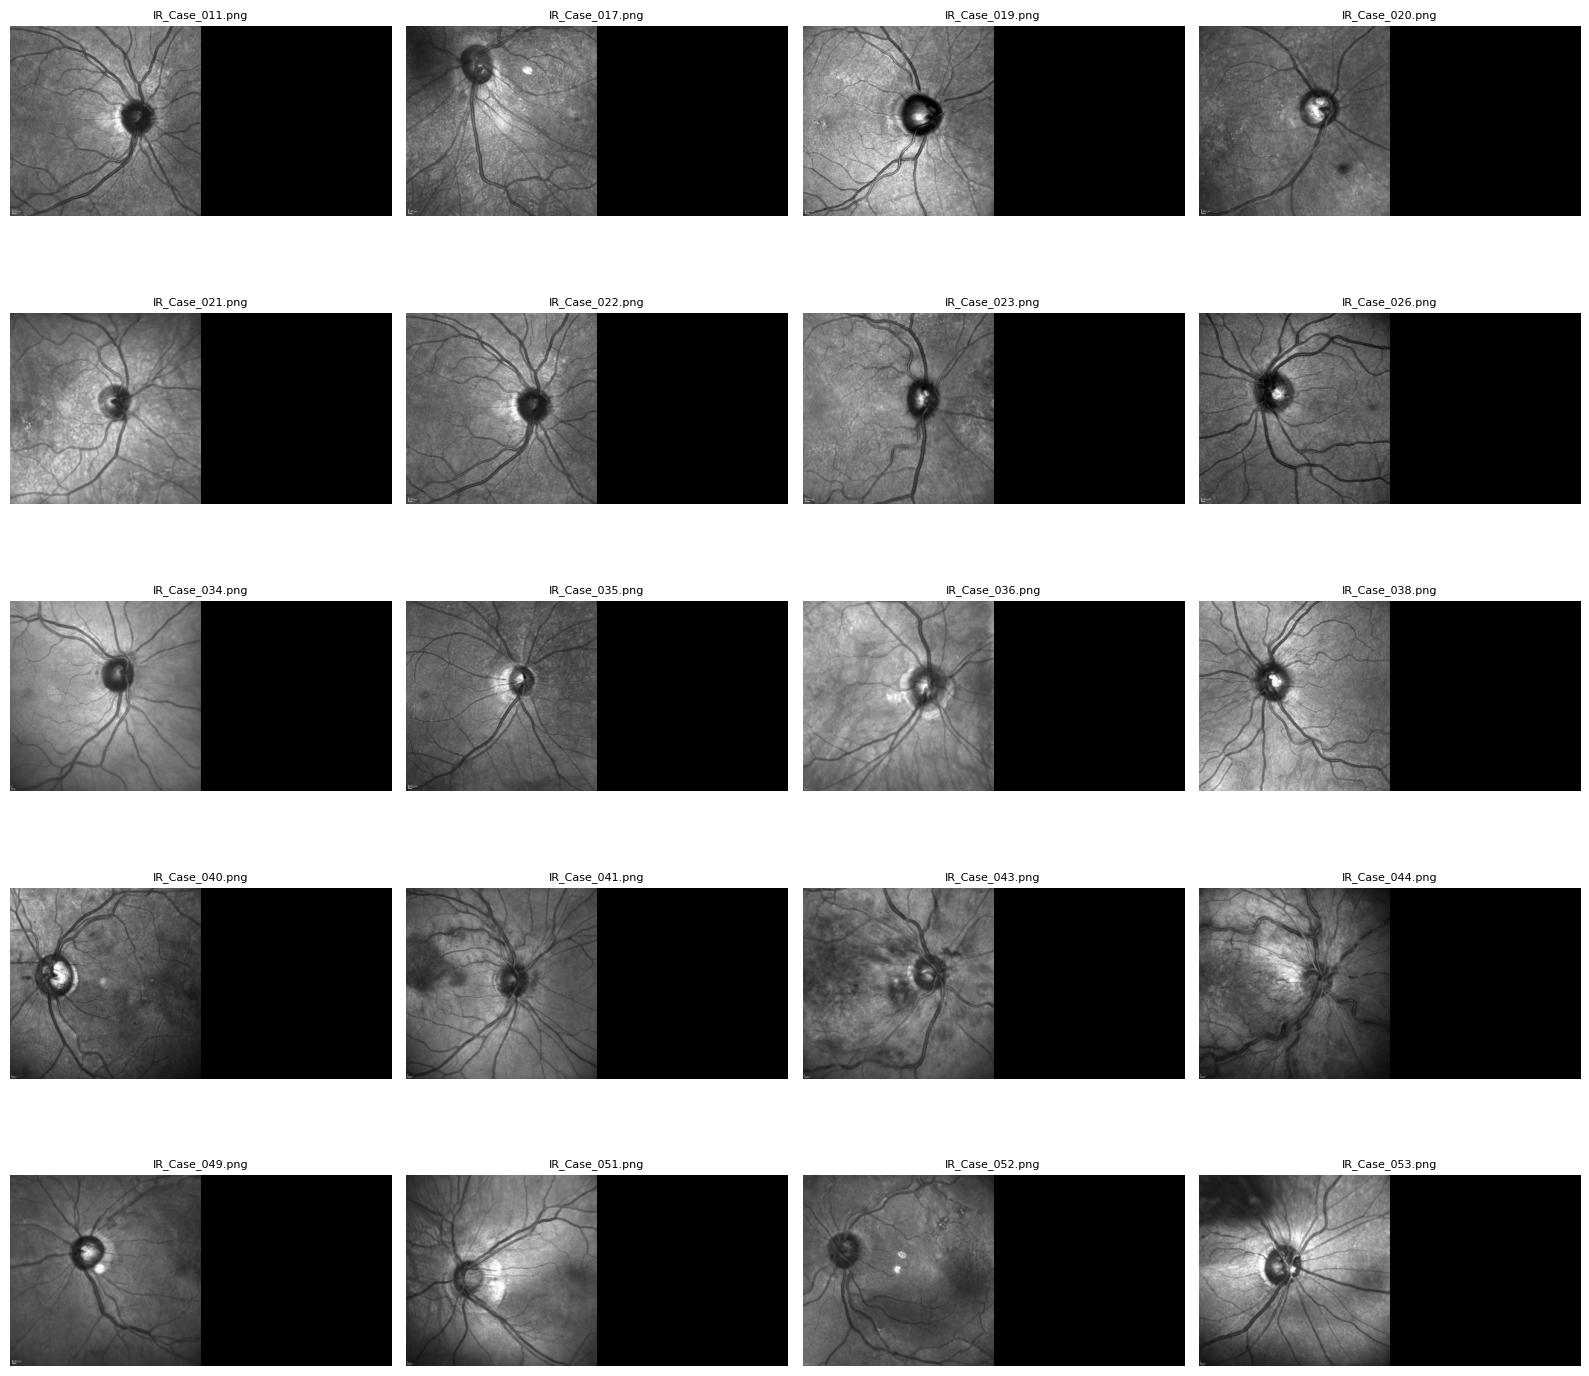

Predictions saved to c:\Users\User\4TC\S1 - Tohoku\Labo\try_1\predictions_on_train and first 20 displayed


In [9]:
orig_imgs_dir = parent / 'RAVIR Dataset' / 'train' / 'training_images'
out_dir = parent / 'try_1' / 'predictions_on_train'
out_dir.mkdir(parents=True, exist_ok=True)

model.eval()
img_paths = sorted(list(orig_imgs_dir.glob('*.png')))
max_show = min(20, len(img_paths))
cols = 4
rows = int(np.ceil(max_show / cols))
plt.figure(figsize=(cols*4, rows*3))

for i, p in enumerate(img_paths[:max_show]):
    img_pil = Image.open(p).convert('RGB').resize(IMG_SIZE, Image.BILINEAR)
    img_arr = np.array(img_pil, dtype=np.float32)/255.0
    img_t = torch.from_numpy(np.transpose(img_arr, (2,0,1))).unsqueeze(0).float().to(device)
    with torch.no_grad():
        out = model(img_t)
        pred = out.argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8)
    pred_col = colorize_mask(pred)
    # save prediction colored
    Image.fromarray(pred_col).save(out_dir / p.name)
    ax = plt.subplot(rows, cols, i+1)
    display_img = np.hstack((np.array(img_pil), pred_col))
    ax.imshow(display_img)
    ax.set_title(p.name, fontsize=8)
    ax.axis('off')

plt.tight_layout(); plt.show()
print('Predictions saved to', out_dir, 'and first', max_show, 'displayed')

In [ ]:
Idées (prioritaires)

Utiliser des poids de classes dans la loss (CrossEntropyLoss(weight=...)) : donner beaucoup plus d'importance aux classes 1 et 2.
Combiner CrossEntropy + Dice (ou Tversky) — Dice améliore les petites structures.
Focal Loss (pénalise les faux négatifs des classes rares).
Oversampling / WeightedRandomSampler : échantillonner plus d'images contenant des vaisseaux.
Per-pixel weighting maps (ex : poids plus élevés autour des vaisseaux/bords via dilation).
Augmentation ciblée (augmenter cas contenant vaisseaux, elastic, contrast).
Surveiller métriques par classe (IoU par classe) et utiliser early-stop basé sur mean_iou (pour éviter colapsus vers background).
Exemples de code à insérer/ remplacer dans ton notebook.

# UNet — idées et correction d'erreur (version forte)

On revient à la stratégie plus agressive :
- poids de classes importants pour favoriser fortement les classes 1 et 2,
- pénalité forte (différentiable) pour probabilités élevées de la classe 0 sur pixels GT=1/2.
Attention : surveiller collapse et ajuster si nécessaire.

In [18]:
# Weighted loss + strong penalty on predicting class 0 where GT is 1/2 (hard version)
import torch.nn.functional as F

# Poids de classes plus élevés (version agressive)
class_weights = torch.tensor([1.0, 5.0, 5.0], device=device)
criterion_w = nn.CrossEntropyLoss(weight=class_weights)
# Pénalité forte : pas de threshold, moyenne de prob(class0) sur pixels positifs
lambda_penalty = 4.0

# Nouveau modèle (même architecture) et optimizer
model_w = UNet().to(device)
optimizer_w = optim.Adam(model_w.parameters(), lr=LR)

# Reuse dataset definitions (RAVIRDataset) and dirs defined earlier
train_ds_w = RAVIRDataset(train_imgs_dir, train_masks_dir, IMG_SIZE)
val_ds_w = RAVIRDataset(val_imgs_dir, val_masks_dir, IMG_SIZE)
train_loader_w = DataLoader(train_ds_w, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_w = DataLoader(val_ds_w, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

EPOCHS_W = 300  # l'utilisateur va augmenter le nombre d'epochs si besoin
history_w = {'train_loss':[], 'val_loss':[], 'train_miou':[], 'val_miou':[]}

for epoch in range(1, EPOCHS_W+1):
    model_w.train()
    running_loss = 0.0
    miou_sum = 0.0
    batches = 0
    for imgs, masks in train_loader_w:
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer_w.zero_grad()
        outputs = model_w(imgs)  # logits N,C,H,W
        ce = criterion_w(outputs, masks)
        # Probabilités pour la classe 0
        probs = F.softmax(outputs, dim=1)  # N,C,H,W
        pos_mask = (masks > 0).float()     # N,H,W -> pixels à protéger (1 ou 2)
        prob0 = probs[:, 0, :, :]          # N,H,W
        pos_count = pos_mask.sum()
        if pos_count.item() > 0:
            # moyenne de prob(class0) sur pixels où GT != 0
            penalty = lambda_penalty * (prob0 * pos_mask).sum() / pos_count
        else:
            penalty = torch.tensor(0.0, device=device)
        loss = ce + penalty
        loss.backward()
        optimizer_w.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        miou_sum += compute_mean_iou(preds.cpu(), masks.cpu())
        batches += 1
    train_loss = running_loss / len(train_ds_w) if len(train_ds_w)>0 else 0
    train_miou = miou_sum / batches if batches>0 else 0

    # Validation
    model_w.eval()
    val_loss = 0.0
    miou_sum = 0.0
    batches = 0
    with torch.no_grad():
        for imgs, masks in val_loader_w:
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model_w(imgs)
            ce = criterion_w(outputs, masks)
            probs = F.softmax(outputs, dim=1)
            pos_mask = (masks > 0).float()
            prob0 = probs[:, 0, :, :]
            pos_count = pos_mask.sum()
            penalty = (lambda_penalty * (prob0 * pos_mask).sum() / pos_count) if pos_count.item()>0 else torch.tensor(0.0, device=device)
            loss = ce + penalty
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            miou_sum += compute_mean_iou(preds.cpu(), masks.cpu())
            batches += 1
    val_loss = val_loss / len(val_ds_w) if len(val_ds_w)>0 else 0
    val_miou = miou_sum / batches if batches>0 else 0
    history_w['train_loss'].append(train_loss)
    history_w['val_loss'].append(val_loss)
    history_w['train_miou'].append(train_miou)
    history_w['val_miou'].append(val_miou)
    print(f'[weighted-hard] Epoch {epoch}/{EPOCHS_W} - train_loss: {train_loss:.4f} val_loss: {val_loss:.4f} train_miou: {train_miou:.4f} val_miou: {val_miou:.4f}')

# Sauvegarde du modèle entraîné (pondéré + pénalité forte)
save_dir_w = parent / 'try_1'
model_path_w = save_dir_w / 'unet_pytorch_weighted_hard_300_epoch.pth'
torch.save(model_w.state_dict(), str(model_path_w))
print('Saved weighted-hard model to', model_path_w)

[weighted-hard] Epoch 1/300 - train_loss: 2.3204 val_loss: 2.3176 train_miou: 0.0241 val_miou: 0.0228
[weighted-hard] Epoch 2/300 - train_loss: 2.3163 val_loss: 2.3137 train_miou: 0.0237 val_miou: 0.0228
[weighted-hard] Epoch 2/300 - train_loss: 2.3163 val_loss: 2.3137 train_miou: 0.0237 val_miou: 0.0228
[weighted-hard] Epoch 3/300 - train_loss: 2.3123 val_loss: 2.3099 train_miou: 0.0249 val_miou: 0.0228
[weighted-hard] Epoch 3/300 - train_loss: 2.3123 val_loss: 2.3099 train_miou: 0.0249 val_miou: 0.0228
[weighted-hard] Epoch 4/300 - train_loss: 2.3086 val_loss: 2.3061 train_miou: 0.0265 val_miou: 0.0228
[weighted-hard] Epoch 4/300 - train_loss: 2.3086 val_loss: 2.3061 train_miou: 0.0265 val_miou: 0.0228
[weighted-hard] Epoch 5/300 - train_loss: 2.3046 val_loss: 2.3020 train_miou: 0.0254 val_miou: 0.0228
[weighted-hard] Epoch 5/300 - train_loss: 2.3046 val_loss: 2.3020 train_miou: 0.0254 val_miou: 0.0228
[weighted-hard] Epoch 6/300 - train_loss: 2.3009 val_loss: 2.2976 train_miou: 0.02

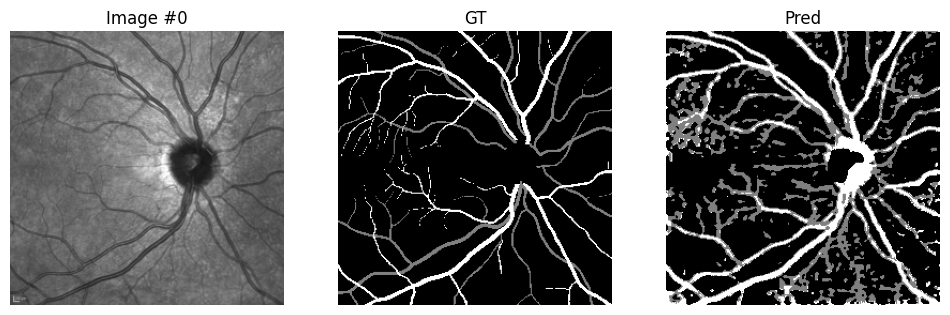

Image 0 - PixelAcc: 0.7688  MeanIoU: 0.4227  MeanDice: 0.5432
  Class 0 IoU: 0.7901900717120379  Dice: 0.8828001944579484
  Class 1 IoU: 0.34680732926152136  Dice: 0.5150065963060686
  Class 2 IoU: 0.13114984537531627  Dice: 0.2318876599975146


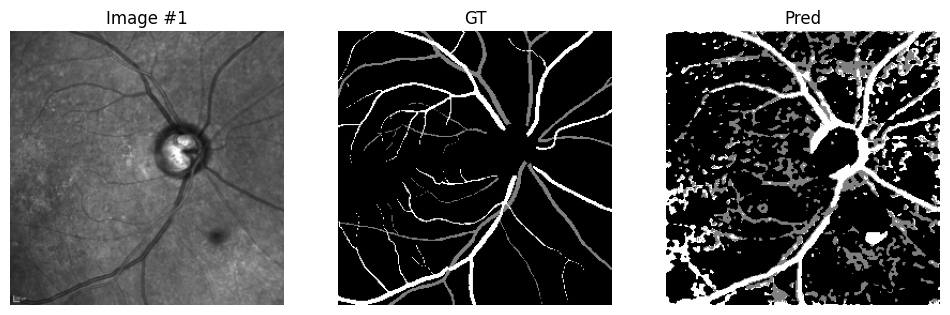

Image 1 - PixelAcc: 0.7742  MeanIoU: 0.3980  MeanDice: 0.5184
  Class 0 IoU: 0.7789209115281501  Dice: 0.8757229244767628
  Class 1 IoU: 0.2675171932622346  Dice: 0.4221121333647873
  Class 2 IoU: 0.14763204971283306  Dice: 0.2572811551398802


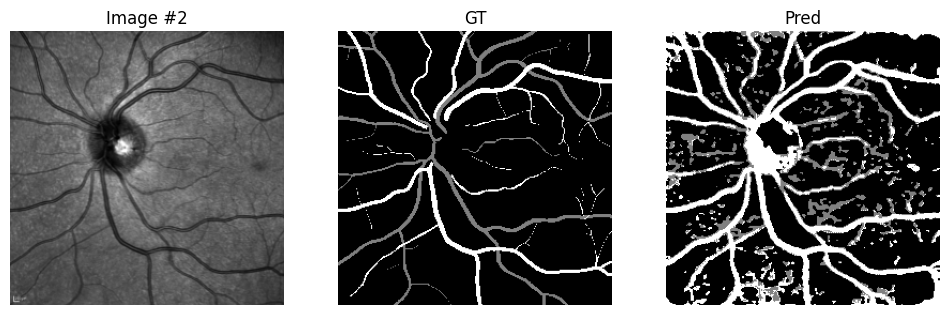

Image 2 - PixelAcc: 0.7523  MeanIoU: 0.3618  MeanDice: 0.4564
  Class 0 IoU: 0.7848499515972894  Dice: 0.8794576271186441
  Class 1 IoU: 0.26129298074762153  Dice: 0.41432559244520994
  Class 2 IoU: 0.03926206244087039  Dice: 0.0755575785161584


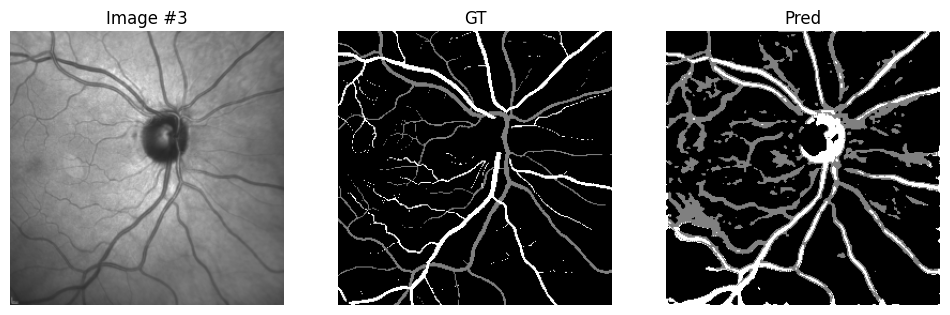

Image 3 - PixelAcc: 0.8049  MeanIoU: 0.4347  MeanDice: 0.5543
  Class 0 IoU: 0.8296529428869541  Dice: 0.9068965194873185
  Class 1 IoU: 0.30889188783925625  Dice: 0.4719899186619315
  Class 2 IoU: 0.16555488174651303  Dice: 0.28407908428720086


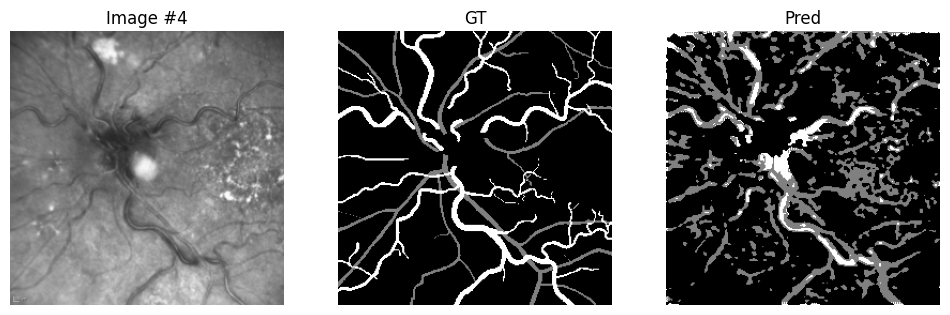

Image 4 - PixelAcc: 0.7467  MeanIoU: 0.3587  MeanDice: 0.4640
  Class 0 IoU: 0.7795205479452055  Dice: 0.8761017666756475
  Class 1 IoU: 0.1607466943220119  Dice: 0.27697118606209514
  Class 2 IoU: 0.13570536828963795  Dice: 0.2389798834780697


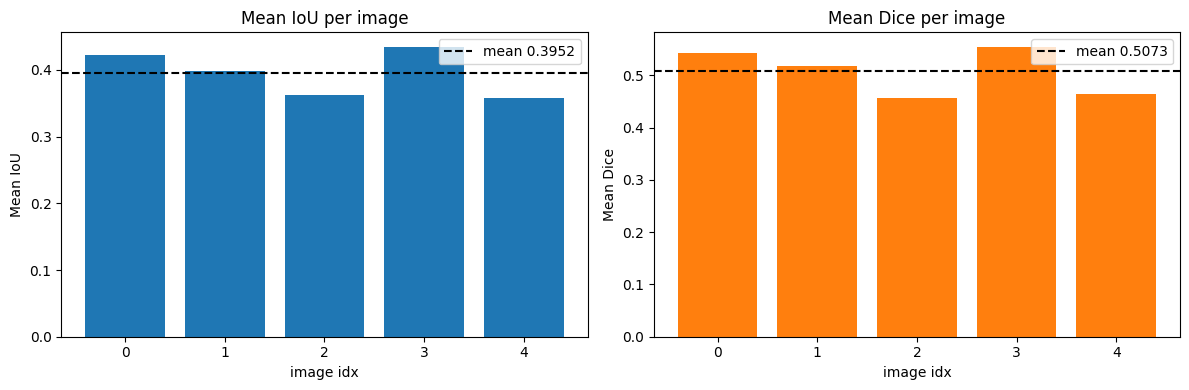

Averages over shown images -> Mean IoU: 0.39517964791116356  Mean Dice: 0.5072779880316824


In [19]:
# Évaluation détaillée sur les 5 premières images de validation: IoU, Dice, pixel-acc par image + plot
def dice_score(pred, gt, cls):
    pred_c = (pred == cls)
    gt_c = (gt == cls)
    inter = (pred_c & gt_c).sum()
    denom = pred_c.sum() + gt_c.sum()
    if denom == 0:
        return float('nan')
    return (2.0 * inter) / denom

def iou_score(pred, gt, cls):
    pred_c = (pred == cls)
    gt_c = (gt == cls)
    inter = (pred_c & gt_c).sum()
    union = (pred_c | gt_c).sum()
    if union == 0:
        return float('nan')
    return inter / union

def eval_and_plot_per_image(model, ds, n_images=5):
    model.eval()
    n_show = min(n_images, len(ds))
    per_image_metrics = []
    for idx in range(n_show):
        img_t, mask_t = ds[idx]
        img = img_t.unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(img)
            pred = out.argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8)
        gt = mask_t.numpy().astype(np.uint8)
        pix_acc = (pred == gt).sum() / gt.size
        ious = [iou_score(pred, gt, c) for c in range(NUM_CLASSES)]
        dices = [dice_score(pred, gt, c) for c in range(NUM_CLASSES)]
        mean_iou = np.nanmean(ious)
        mean_dice = np.nanmean(dices)
        per_image_metrics.append({'idx': idx, 'pix_acc': pix_acc, 'ious': ious, 'dices': dices, 'mean_iou': mean_iou, 'mean_dice': mean_dice})
        # display
        img_disp = np.transpose(img_t.numpy(), (1,2,0))
        gt_col = colorize_mask(gt)
        pred_col = colorize_mask(pred)
        fig, axes = plt.subplots(1,3, figsize=(12,4))
        axes[0].imshow(img_disp); axes[0].set_title(f'Image #{idx}'); axes[0].axis('off')
        axes[1].imshow(gt_col); axes[1].set_title('GT'); axes[1].axis('off')
        axes[2].imshow(pred_col); axes[2].set_title('Pred'); axes[2].axis('off')
        plt.show()
        # print metrics for this image
        print(f'Image {idx} - PixelAcc: {pix_acc:.4f}  MeanIoU: {mean_iou:.4f}  MeanDice: {mean_dice:.4f}')
        for c in range(NUM_CLASSES):
            print(f'  Class {c} IoU: {ious[c] if not np.isnan(ious[c]) else "n/a"}  Dice: {dices[c] if not np.isnan(dices[c]) else "n/a"}')

    # plotting summary (mean IoU and mean Dice per image)
    imgs = [m['idx'] for m in per_image_metrics]
    mean_ious = [m['mean_iou'] for m in per_image_metrics]
    mean_dices = [m['mean_dice'] for m in per_image_metrics]
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].bar(imgs, mean_ious, color='C0')
    ax[0].axhline(np.nanmean(mean_ious), color='k', linestyle='--', label=f'mean {np.nanmean(mean_ious):.4f}')
    ax[0].set_title('Mean IoU per image'); ax[0].set_xlabel('image idx'); ax[0].set_ylabel('Mean IoU'); ax[0].legend()
    ax[1].bar(imgs, mean_dices, color='C1')
    ax[1].axhline(np.nanmean(mean_dices), color='k', linestyle='--', label=f'mean {np.nanmean(mean_dices):.4f}')
    ax[1].set_title('Mean Dice per image'); ax[1].set_xlabel('image idx'); ax[1].set_ylabel('Mean Dice'); ax[1].legend()
    plt.tight_layout(); plt.show()
    print('Averages over shown images -> Mean IoU:', np.nanmean(mean_ious), ' Mean Dice:', np.nanmean(mean_dices))
    return per_image_metrics

# run evaluation on first 5 validation images
per_image_metrics_hard = eval_and_plot_per_image(model_w, val_ds_w, n_images=5)